# Spotify Music Recommendation
I've been an avid Spotify user since 2016 and what I always loved about Spotify was their song recommendation algorithms. Whether it be from the "radio" feature or the "discovery weekly" auto-generated playlist, Spotify always had a knack for finding the songs that best suit my music preferences. 

I knew that Spotify has tons of listening data from the yearly "spotify wrapped" recaps so I wanted to see if I could use that data to explore my own preferences and maybe attempt to have a try at creating a model to predict songs myself.

In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

I obtained my Spotify listening history through a .csv drop that is available to all users on their website.

In [2]:
# Importing my Spotify listening history in the past year.  
df = pd.read_csv("StreamingHistory.csv")
df.head()

,endTime,artistName,trackName,msPlayed
0,2019-07-30 23:07,"Tyler, The Creator",Glitter,158890
1,2019-07-31 1:34,Jay Rock,Redemption (feat. SZA),4899
2,2019-07-31 1:34,"Tyler, The Creator","Enjoy Right Now, Today",34071
3,2019-07-31 1:34,"Tyler, The Creator",Glitter,65913
4,2019-07-31 1:35,Playboi Carti,Magnolia,5456


My raw listening history may contain songs that were only listened very occasionally or by accident, which may not accuratly reflect my music preferences. We can use a histogram to see the frequency of songs with a certain # of plays so that we can determine what makes a song that fits my music preference.

Text(0.5, 0, '# of plays')

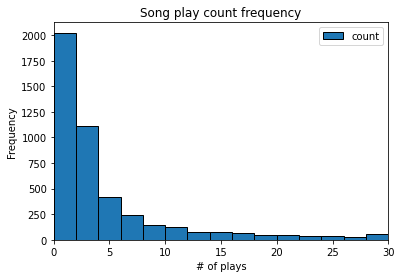

In [3]:
#Creating a histogram where frequency is seperated into columns of 2s
bins = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]
ax = df.groupby(['trackName']).size().to_frame('count').plot(kind='hist',bins=bins, edgecolor='black')
ax.set_xlim(0,30)
ax.set_title("Song play count frequency")
ax.set_xlabel("# of plays")

From the histogram we can see that there is a huge drop in frequency of songs with greater than 4 plays. Thus we can eliminate all the songs that do not meet this 4 play minimum requirement to be considered part of my music preference.

In [4]:
# Find number of occurences of each song, and keep songs with 4 or more listens
preference = df.groupby(['artistName','trackName']).size().to_frame('count').reset_index()
preference = preference[preference['count']>4]

In [5]:
# Display first few rows
preference.head()

,artistName,trackName,count
11,10cm,Phonecert 폰서트,5
16,2 Chainz,It's A Vibe,7
20,21 Savage,Bank Account,8
26,21 Savage,Secret (feat. Summer Walker),21
28,21 Savage,a lot,19


In [6]:
print("Number of songs: " + str(preference.shape[0]))

Number of songs: 1365


Now that we have a list of songs that fit my music preferences, we can now join this list with a Kaggle dataset containing the song features of 160k+ songs released in between 1921 and 2020. The specifics of what each feature means are listest here: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

In [7]:
# Import Kaggle spotify song dataset
# https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks
songList = pd.read_csv("SpotifySongs.csv")

In [8]:
# Display first few rows
songList.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [9]:
#I will be dropping track_id since it is not needed for this project. 
songList = songList.drop(columns= ['track_id'])

Now I will create a new column in songList called preference where I will be entering a 1 or 0 depending on whether a song on songList is in my music preferences.

In [10]:
#If the artist and track matches then we will add 1 to the preference column.
songList['sameArtist'] = songList.artist_name.isin(preference.artistName) 
songList['sameTrack'] = songList.track_name.isin(preference.trackName) 
songList["preference"] = np.where((songList["sameArtist"] == True) & (songList["sameTrack"] == True),1,0)
songList = songList.drop(["sameArtist","sameTrack"],axis=1)

In [11]:
songList.head()

,genre,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,preference
0,Movie,Henri Salvador,C'est beau de faire un Show,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814,0
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816,0
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368,0
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227,0
4,Movie,Fabien Nataf,Ouverture,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390,0


I want to create a seperate dataframe with just my preferred songs and their features for future analysis.

In [12]:
myPreferences = songList[songList["preference"] == 1]

In [13]:
myPreferences.head()

,genre,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,preference
138,R&B,Surfaces,Heaven Falls / Fall on Me,61,0.3600,0.563,240597,0.366,0.002430,B,0.0955,-6.896,Minor,0.1210,85.352,4/4,0.768,1
148,R&B,TWENTY88,On The Way,61,0.0808,0.584,203227,0.687,0.000000,C#,0.2000,-7.176,Minor,0.3210,129.902,4/4,0.324,1
154,R&B,SZA,Childs Play (feat. Chance the Rapper),65,0.7750,0.759,216234,0.342,0.000000,C#,0.1120,-9.044,Minor,0.0406,99.995,4/4,0.220,1
155,R&B,Kyle Dion,Brown,63,0.0759,0.546,234759,0.698,0.000131,C,0.0613,-4.678,Major,0.0987,72.417,4/4,0.616,1
176,R&B,Dijon,Skin,62,0.5120,0.674,230625,0.616,0.000002,G,0.3310,-3.471,Major,0.0272,94.934,4/4,0.551,1


Since there are a lot of features for each song, I want to see which ones have the greatest effect on whether a song would be in my preferences. I will use a seaborn correlation matrix heat map to visualize the effect of the feature on preference.

In [14]:
#I am going to drop popularity and duration since I do not want these features of a song to affect my predictions.
songList = songList.drop(columns= ['popularity','duration_ms'])

<AxesSubplot:>

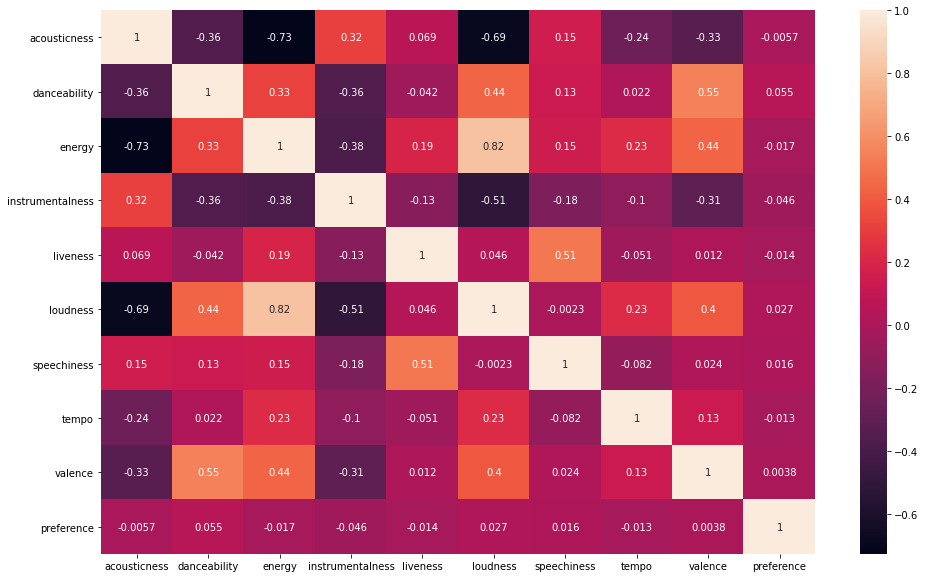

In [15]:
#seaborn heatmap
corrMatrix = songList.corr()
plt.figure(figsize = (16,10))
sns.heatmap(corrMatrix, annot=True)

From this plot we can see that danceability (0.055), instrumentalness (-0.046), loudness (0.027), and energy (-0.016) have the greatest correlation with preference. 
With these features in mind we can now try to predict which other songs in the datase that I may also enjoy. 

In [16]:
#First checking the balance of major and minority classes
songList.preference.value_counts()

0    230050
1      2675
Name: preference, dtype: int64

We can see that the dataset is very imbalanced with 98.8% of songs having a 0. Thus we have to try to balance the two classes or else the majority of predictions would end up being 0.

In [17]:
#top genres in my preferences
myPreferences["genre"].value_counts()

R&B                 482
Rap                 399
Pop                 385
Hip-Hop             339
Alternative         258
Soul                235
Children’s Music    226
Indie               215
Dance                59
Rock                 29
Blues                21
Jazz                 19
Folk                  5
Electronic            1
Soundtrack            1
Reggae                1
Name: genre, dtype: int64

I will first try to undersample from the majority class by limiting the genres to only ones that contains more than 200 songs from my preferences.

In [18]:
myGenres = ["R&B","Rap","Pop","Hip-Hop","Alternative","Soul","Children’s Music","Indie"]
songList = songList[songList.genre.isin(myGenres)]

In [19]:
songList

,genre,artist_name,track_name,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,preference
135,R&B,Mary J. Blige,Be Without You - Kendu Mix,0.08300,0.724,0.689,0.000000,D,0.3040,-5.922,Minor,0.1350,146.496,4/4,0.6930,0
136,R&B,Rihanna,Desperado,0.32300,0.685,0.610,0.000000,C,0.1020,-5.221,Minor,0.0439,94.384,3/4,0.3230,0
137,R&B,Yung Bleu,Ice On My Baby (feat. Kevin Gates) - Remix,0.06750,0.762,0.520,0.000004,F,0.1140,-5.237,Minor,0.0959,75.047,4/4,0.0862,0
138,R&B,Surfaces,Heaven Falls / Fall on Me,0.36000,0.563,0.366,0.002430,B,0.0955,-6.896,Minor,0.1210,85.352,4/4,0.7680,1
139,R&B,Olivia O'Brien,Love Myself,0.59600,0.653,0.621,0.000000,B,0.0811,-5.721,Minor,0.0409,100.006,4/4,0.4660,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,0.00384,0.687,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.9620,0
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,0.03290,0.785,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.9690,0
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,0.90100,0.517,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.8130,0
232723,Soul,R.LUM.R,With My Words,0.26200,0.745,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.4890,0


In [20]:
songList.preference.value_counts()

0    71614
1     2539
Name: preference, dtype: int64

This slightly improved the balance of the dataset, but it is still greatly imbalanced. Another way we can improve the balance is to over sample the minority class using SMOTE to generate synthetic samples. But before that we must split our dataset into train and validation sets to prevent data leakage. 

In [21]:
# First split the dataset
y = songList.preference   
# using the features with the most correlation with preference as we identified earlier
X = songList[["danceability", "instrumentalness", "loudness", "energy"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<AxesSubplot:>

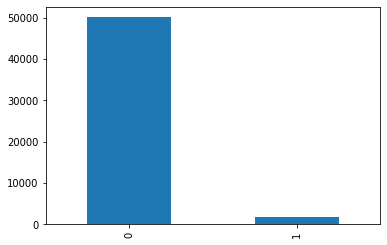

In [22]:
#see the balance of classes before SMOTE
pd.Series(y_train).value_counts().plot.bar()

In [23]:
#apply SMOTE to the training sample
sm = SMOTE(random_state = 33)
X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

<AxesSubplot:>

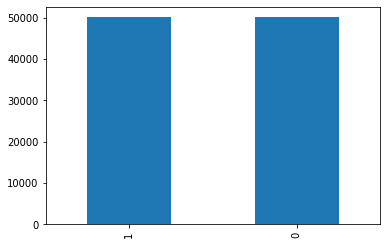

In [24]:
#see the balance of classes after SMOTE
pd.Series(y_train_new).value_counts().plot.bar()

Now that we have a balanced sample, we can now fit a model. I will use three different models (logistic regression, random forest, and gradient boosting) to see which one will perform better with this dataset. We will use F1 score to measure performance as I want to consider both recall and precision since I want to limit the number of Type I and II errors.

In [25]:
#Fitting and predicting using a Logistic Regression model
regr = lm.LogisticRegression()
regr.fit(X_train_new,y_train_new)
resultLR = regr.predict(X_test)

In [26]:
#Displaying the confusion matrix
print('Confusion Matrix - Logistic Regression')
print(pd.crosstab(y_test, resultLR, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Logistic Regression
Predicted      0     1    All
True                         
0          12798  8686  21484
1            261   501    762
All        13059  9187  22246


In [27]:
#Displaying the F1 score
print('F1 score - Logistic Regression:')
print(f1_score(y_test, resultLR, average='macro'))

F1 score - Logistic Regression:
0.4208515654601809


In [28]:
#Fitting and predicting using a Random Forest model, I found that 200 estimators allowed for the best F1 score. 
rf_regr = RandomForestRegressor(n_estimators=200, random_state=0)
rf_regr.fit(X_train_new, y_train_new)
resultRF = rf_regr.predict(X_test)
resultRF = resultRF.round(0)

In [29]:
#Displaying the confusion matrix
print('Confusion Matrix - Random Forest')
print(pd.crosstab(y_test, resultRF, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Random Forest
Predicted    0.0   1.0    All
True                         
0          20991   493  21484
1            121   641    762
All        21112  1134  22246


In [30]:
#Displaying the F1 score
print('F1 score - Random Forest:')
print(f1_score(y_test, resultRF, average='macro'))

F1 score - Random Forest:
0.8308729192693753


In [31]:
#Fitting and predicting using gradient boosting, I found that 2250 estimators allowed for the best F1 score. 
xgb = XGBClassifier(n_estimators=2250, random_state=0)
xgb.fit(X_train_new, y_train_new)
resultXGB = xgb.predict(X_test)
resultXGB = resultXGB.round(0)

In [32]:
#Displaying the confusion matrix
print('Confusion Matrix - XGBClassifier')
print(pd.crosstab(y_test, resultXGB, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - XGBClassifier
Predicted      0    1    All
True                        
0          21275  209  21484
1            127  635    762
All        21402  844  22246


In [33]:
print('F1 score - XGBClassifier:')
print(f1_score(y_test, resultXGB, average='macro'))

F1 score - XGBClassifier:
0.8914749166445444


From these results we can see that XGBoost had the best F1 score (0.85) and it had the least amount of Type I and II errors so I will use that model in the final prediction.

In [34]:
#Using the XGBclassifier model we trained to predict on the songList.
final_prediction = xgb.predict(songList[["danceability", "instrumentalness", "loudness", "energy"]])
songList["prediction"] = final_prediction

In [35]:
#Filtering songs to ones that were not already in my preferences.
songList = songList[(songList["preference"] == 0) & (songList["prediction"] == 1)]

In [36]:
songList

,genre,artist_name,track_name,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,preference,prediction
1190,Alternative,Nirvana,Heart-Shaped Box,0.184000,0.494,0.677,0.025800,F#,0.0926,-10.233,Major,0.0452,101.539,4/4,0.316,0,1
2637,Alternative,311,Don't You Worry,0.001950,0.322,0.789,0.000014,C,0.1050,-6.788,Major,0.0546,137.017,4/4,0.123,0,1
2795,Alternative,Silverchair,Tomorrow,0.000412,0.312,0.693,0.000180,D,0.1050,-7.097,Major,0.0326,144.883,4/4,0.519,0,1
3318,Alternative,Francis and the Lights,May I Have This Dance,0.469000,0.576,0.451,0.038900,G#,0.0876,-9.571,Major,0.0444,90.439,4/4,0.803,0,1
5231,Alternative,Kari Jobe,In The Name Of Love - Recorded At Spotify Stud...,0.571000,0.678,0.376,0.000000,F#,0.1110,-9.031,Major,0.0418,133.985,4/4,0.183,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232135,Soul,Johnny Griffin,Nice And Easy - Rudy Van Gelder Edition/Remast...,0.807000,0.624,0.358,0.389000,F,0.1060,-9.243,Minor,0.0396,123.666,4/4,0.506,0,1
232259,Soul,Total,Sitting Home,0.371000,0.552,0.672,0.015900,A#,0.0671,-9.772,Minor,0.0888,126.791,5/4,0.630,0,1
232454,Soul,The Isley Brothers,Mission To Please You,0.690000,0.715,0.392,0.035400,B,0.1140,-10.873,Minor,0.0410,88.830,4/4,0.460,0,1
232524,Soul,Bobby Womack,Harry Hippie,0.523000,0.387,0.235,0.000040,E,0.2550,-16.647,Major,0.0371,74.216,4/4,0.613,0,1


In [37]:
songList.to_csv("song-recommendations.csv")

Now that I have a csv file of the recommended songs from the model. I used a free website: https://www.tunemymusic.com/CSV-to-Spotify.php to create a playlist with the list of recommended songs on my spotify account. 

After listening to the playlist of songs my model curated, there were songs that I greatly enjoyed that I have never discovered before but there were also songs that were not so plesant. However, this was a very interesting experience for me to explore how to create a song recommendation program. It allows me to appreciate the advanced models/algorithms companies such as Spotify use to create such good recommendation programs and motivates me to do further research and learn what goes into these programs.